# [Unit 13] Part 3：綠色溶劑篩選 (Green Solvent Screening)

**課程名稱**：化工資料科學與機器學習實務（CHE-AI-101）  
**Part 3 單元**：非監督式學習應用

**本單元目標**：
1.  **資料庫建立**：建立一個包含沸點、極性與毒性的溶劑性質資料庫
2.  **非監督式學習**：使用 **K-Means** 演算法將性質相似的溶劑分群
3.  **降維視覺化**：利用 **PCA (主成分分析)** 將多維特徵投影到 2D 平面，直觀觀察溶劑間的相似性
4.  **替代品搜尋**：在同一群組中尋找毒性較低的「綠色替代溶劑」

**為什麼需要 AI 篩選溶劑？**
傳統試錯法 (Trial-and-Error) 尋找替代溶劑耗時且昂貴。透過機器學習的分群技術，我們可以快速縮小搜尋範圍，找到物理性質相似但更環保的候選者。

In [1]:
# 匯入必要的套件
import os

# 設定環境變數以避免 Windows 下 KMeans 的記憶體洩漏警告
# 注意：必須在匯入 numpy 或 sklearn 之前設定，否則可能無效
os.environ['OMP_NUM_THREADS'] = '1'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 建立結果儲存資料夾
os.makedirs('Unit13_Results', exist_ok=True)

# 圖形設定
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
#plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei", "Noto Sans CJK TC", "sans-serif"]
plt.rcParams["axes.unicode_minus"] = False

print("套件載入完成！輸出將儲存至：Unit13_Results/")

套件載入完成！輸出將儲存至：Unit13_Results/


---
## 1. 資料探索分析 (Exploratory Data Analysis)

在進行機器學習前，先透過視覺化了解資料的基本特性與分佈。

In [2]:
### 1.1 建立溶劑資料庫

# 建立包含 15 種常見化工溶劑的資料庫
data = {
    "Solvent": [
        "Benzene", "Toluene", "Xylene", "Water", "Ethanol", 
        "Methanol", "Isopropanol", "Acetone", "MEK", "Hexane", 
        "Heptane", "Cyclohexane", "Chloroform", "DCM", "Ethyl Acetate"
    ],
    "BoilingPoint": [
        80.1, 110.6, 144.4, 100.0, 78.4, 
        64.7, 82.6, 56.1, 79.6, 68.0, 
        98.4, 80.7, 61.2, 39.6, 77.1
    ],
    "Polarity": [
        2.7, 2.4, 2.5, 10.2, 5.2, 
        5.1, 3.9, 5.1, 4.7, 0.1, 
        0.1, 0.2, 4.1, 3.1, 4.4
    ],
    "Toxicity": [
        5, 4, 3, 0, 1, 
        3, 1, 2, 2, 2, 
        1, 2, 4, 3, 1
    ]
}

df = pd.DataFrame(data)
print(f"資料庫包含 {len(df)} 種溶劑。\n")

# 顯示基本統計資訊
print("📊 資料基本統計：")
print(df[["BoilingPoint", "Polarity", "Toxicity"]].describe().round(2))
print("\n")
display(df)

資料庫包含 15 種溶劑。

📊 資料基本統計：
       BoilingPoint  Polarity  Toxicity
count         15.00     15.00     15.00
mean          81.43      3.59      2.27
std           24.99      2.57      1.39
min           39.60      0.10      0.00
25%           66.35      2.45      1.00
50%           79.60      3.90      2.00
75%           90.50      4.90      3.00
max          144.40     10.20      5.00




,Solvent,BoilingPoint,Polarity,Toxicity
0,Benzene,80.1,2.7,5
1,Toluene,110.6,2.4,4
2,Xylene,144.4,2.5,3
3,Water,100.0,10.2,0
4,Ethanol,78.4,5.2,1
5,Methanol,64.7,5.1,3
6,Isopropanol,82.6,3.9,1
7,Acetone,56.1,5.1,2
8,MEK,79.6,4.7,2
9,Hexane,68.0,0.1,2


### 1.2 資料分佈視覺化

視覺化各特徵的分佈與相關性，幫助我們理解資料特性。

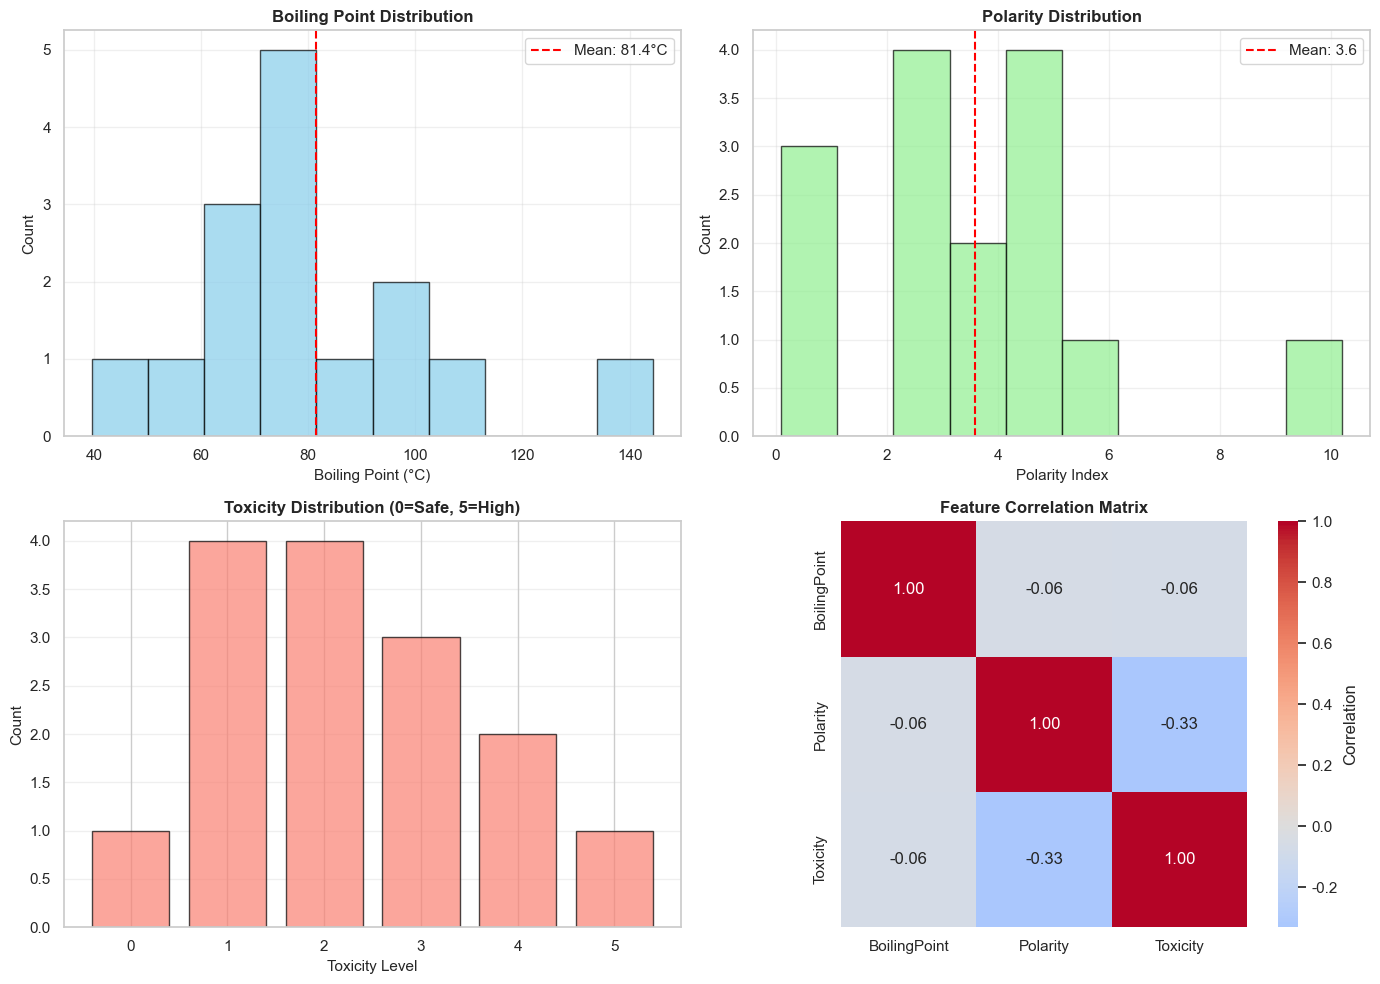

✓ 資料分佈圖已儲存至 Unit09_Results/data_distribution.png

📌 重點觀察：
  • 沸點範圍：39.6 - 144.4 °C（變異大）
  • 極性範圍：0.1 - 10.2（跨越非極性到極性）
  • 毒性等級：主要集中在 1-3 級，只有少數高毒性溶劑（4-5 級）


In [3]:
# 建立多子圖視覺化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Boiling point distribution histogram
axes[0, 0].hist(df['BoilingPoint'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['BoilingPoint'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {df["BoilingPoint"].mean():.1f}°C')
axes[0, 0].set_xlabel('Boiling Point (°C)', fontsize=11)
axes[0, 0].set_ylabel('Count', fontsize=11)
axes[0, 0].set_title('Boiling Point Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Polarity distribution histogram
axes[0, 1].hist(df['Polarity'], bins=10, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df['Polarity'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {df["Polarity"].mean():.1f}')
axes[0, 1].set_xlabel('Polarity Index', fontsize=11)
axes[0, 1].set_ylabel('Count', fontsize=11)
axes[0, 1].set_title('Polarity Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Toxicity bar chart
toxicity_counts = df['Toxicity'].value_counts().sort_index()
axes[1, 0].bar(toxicity_counts.index, toxicity_counts.values, 
               color='salmon', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Toxicity Level', fontsize=11)
axes[1, 0].set_ylabel('Count', fontsize=11)
axes[1, 0].set_title('Toxicity Distribution (0=Safe, 5=High)', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(range(6))
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Feature correlation heatmap
corr_matrix = df[["BoilingPoint", "Polarity", "Toxicity"]].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, ax=axes[1, 1], 
            cbar_kws={'label': 'Correlation'})
axes[1, 1].set_title('Feature Correlation Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('Unit13_Results/data_distribution.png', dpi=150)
plt.show()

print("✓ 資料分佈圖已儲存至 Unit09_Results/data_distribution.png")
print("\n📌 重點觀察：")
print(f"  • 沸點範圍：{df['BoilingPoint'].min():.1f} - {df['BoilingPoint'].max():.1f} °C（變異大）")
print(f"  • 極性範圍：{df['Polarity'].min():.1f} - {df['Polarity'].max():.1f}（跨越非極性到極性）")
print(f"  • 毒性等級：主要集中在 1-3 級，只有少數高毒性溶劑（4-5 級）")

---
## 2. 資料標準化 (Standardization)

由於沸點 (60~150) 與極性 (0~10) 的數值範圍差異很大，若直接計算距離，沸點會主導分群結果。
因此，我們必須使用 **StandardScaler** 將所有特徵轉換為平均值為 0、標準差為 1 的分佈。

In [4]:
features = ["BoilingPoint", "Polarity", "Toxicity"]

# 初始化標準化器
scaler = StandardScaler()

# 進行轉換
X_scaled = scaler.fit_transform(df[features])

# 轉回 DataFrame 方便查看
df_scaled = pd.DataFrame(X_scaled, columns=features)
print("標準化後的前 5 筆資料：")
display(df_scaled.head().round(2))

標準化後的前 5 筆資料：


,BoilingPoint,Polarity,Toxicity
0,-0.06,-0.36,2.04
1,1.21,-0.48,1.29
2,2.61,-0.44,0.55
3,0.77,2.66,-1.69
4,-0.13,0.65,-0.95


---
## 3. K-Means 分群分析 (Clustering Analysis)

### 3.1 確定最佳群數 (Elbow Method & Silhouette Analysis)

在進行分群前，我們先使用兩種方法來決定最佳的群數 k。

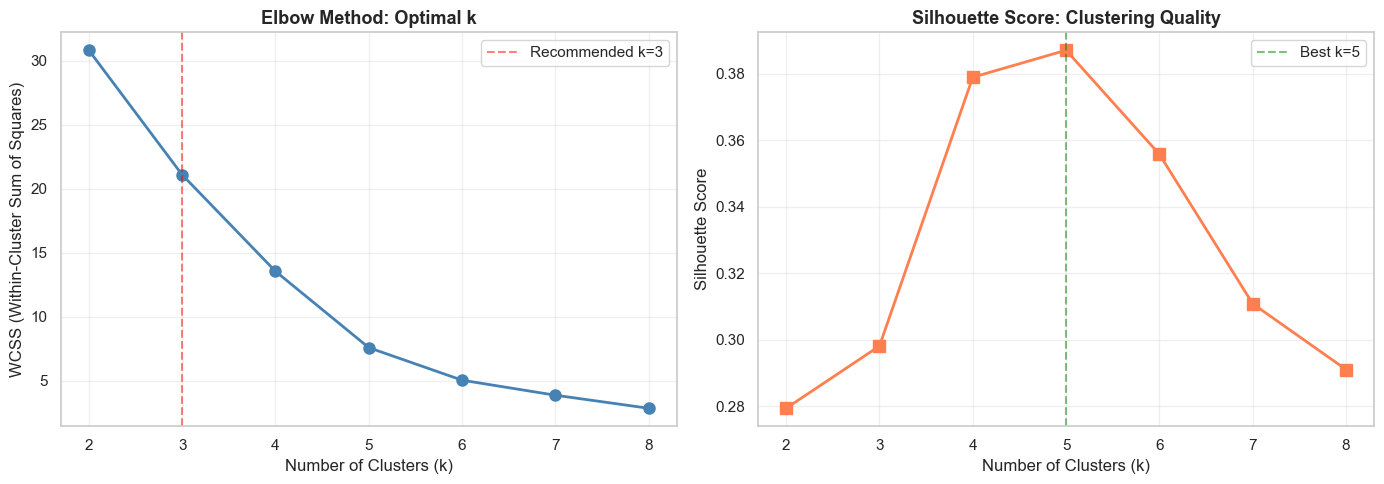

✓ 最佳群數分析圖已儲存

📊 分析結果：
  • Silhouette Score 最高值：k = 5 (分數: 0.387)
  • 手肘法建議：k = 3 (WCSS 下降趨緩點)

💡 結論：綜合兩種方法，本案例採用 k = 3


In [5]:
from sklearn.metrics import silhouette_score

# 測試不同的 k 值（從 2 到 8）
k_range = range(2, 9)
wcss_values = []  # Within-Cluster Sum of Squares (慣性)
silhouette_scores = []  # 輪廓係數

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans_temp.fit_predict(X_scaled)
    
    # 計算 WCSS（群內誤差平方和）
    wcss_values.append(kmeans_temp.inertia_)
    
    # 計算 Silhouette Score
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil_score)

# 繪製雙子圖
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左圖：Elbow Curve（手肘法）
axes[0].plot(k_range, wcss_values, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method: Optimal k', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# 標示建議的 k 值
axes[0].axvline(x=3, color='red', linestyle='--', alpha=0.5, label='Recommended k=3')
axes[0].legend()

# 右圖：Silhouette Score
axes[1].plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='coral')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score: Clustering Quality', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)

# 找出最佳 Silhouette Score
best_k = k_range[np.argmax(silhouette_scores)]
axes[1].axvline(x=best_k, color='green', linestyle='--', alpha=0.5, 
                label=f'Best k={best_k}')
axes[1].legend()

plt.tight_layout()
plt.savefig('Unit13_Results/optimal_k_analysis.png', dpi=150)
plt.show()

print("✓ 最佳群數分析圖已儲存")
print(f"\n📊 分析結果：")
print(f"  • Silhouette Score 最高值：k = {best_k} (分數: {max(silhouette_scores):.3f})")
print(f"  • 手肘法建議：k = 3 (WCSS 下降趨緩點)")
print(f"\n💡 結論：綜合兩種方法，本案例採用 k = 3")

### 3.2 執行 K-Means 分群

In [6]:
# 設定分群數量
n_clusters = 3

# 建立並訓練 K-Means 模型
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X_scaled)

print(f"已完成 K-Means 分群 (k = {n_clusters})")
print(f"最終 WCSS (慣性): {kmeans.inertia_:.2f}\n")

# 查看每一群的成員與平均性質
print("="*70)
for c in range(n_clusters):
    members = df[df["Cluster"] == c]
    print(f"\n【Cluster {c}】成員 ({len(members)} 種溶劑)：")
    print("  " + ", ".join(members["Solvent"].tolist()))
    print(f"  ├─ 平均沸點：{members['BoilingPoint'].mean():.1f} °C (範圍: {members['BoilingPoint'].min():.1f} - {members['BoilingPoint'].max():.1f})")
    print(f"  ├─ 平均極性：{members['Polarity'].mean():.1f} (範圍: {members['Polarity'].min():.1f} - {members['Polarity'].max():.1f})")
    print(f"  └─ 平均毒性：{members['Toxicity'].mean():.1f} (範圍: {members['Toxicity'].min()} - {members['Toxicity'].max()})")
print("="*70)

# 顯示分群結果表格
print("\n完整分群結果：")
display(df[["Solvent", "BoilingPoint", "Polarity", "Toxicity", "Cluster"]].sort_values("Cluster"))

已完成 K-Means 分群 (k = 3)
最終 WCSS (慣性): 21.09


【Cluster 0】成員 (5 種溶劑)：
  Benzene, Methanol, Acetone, Chloroform, DCM
  ├─ 平均沸點：60.3 °C (範圍: 39.6 - 80.1)
  ├─ 平均極性：4.0 (範圍: 2.7 - 5.1)
  └─ 平均毒性：3.4 (範圍: 2 - 5)

【Cluster 1】成員 (5 種溶劑)：
  Water, Ethanol, Isopropanol, MEK, Ethyl Acetate
  ├─ 平均沸點：83.5 °C (範圍: 77.1 - 100.0)
  ├─ 平均極性：5.7 (範圍: 3.9 - 10.2)
  └─ 平均毒性：1.0 (範圍: 0 - 2)

【Cluster 2】成員 (5 種溶劑)：
  Toluene, Xylene, Hexane, Heptane, Cyclohexane
  ├─ 平均沸點：100.4 °C (範圍: 68.0 - 144.4)
  ├─ 平均極性：1.1 (範圍: 0.1 - 2.5)
  └─ 平均毒性：2.4 (範圍: 1 - 4)

完整分群結果：


,Solvent,BoilingPoint,Polarity,Toxicity,Cluster
0,Benzene,80.1,2.7,5,0
5,Methanol,64.7,5.1,3,0
7,Acetone,56.1,5.1,2,0
12,Chloroform,61.2,4.1,4,0
13,DCM,39.6,3.1,3,0
3,Water,100.0,10.2,0,1
4,Ethanol,78.4,5.2,1,1
6,Isopropanol,82.6,3.9,1,1
8,MEK,79.6,4.7,2,1
14,Ethyl Acetate,77.1,4.4,1,1


---
## 4. 尋找替代溶劑 (Finding Alternatives)

假設我們目前的製程使用 **Benzene (苯)**，但它毒性太高 (Toxicity=5)。
我們的策略是：
1.  找出 Benzene 所在的群組 (Cluster)。
2.  在該群組中，篩選出毒性較低的溶劑。

In [7]:
### 4.1 基於分群的替代溶劑搜尋

target_solvent = "Benzene"

# 1. 找出目標溶劑的資訊
target_row = df[df["Solvent"] == target_solvent].iloc[0]
target_cluster = int(target_row["Cluster"])
target_toxicity = float(target_row["Toxicity"])
target_bp = float(target_row["BoilingPoint"])
target_pol = float(target_row["Polarity"])

print(f"🎯 目標溶劑分析：{target_solvent}")
print(f"  ├─ 沸點：{target_bp:.1f} °C")
print(f"  ├─ 極性：{target_pol:.1f}")
print(f"  ├─ 毒性：{target_toxicity} ⚠️ (高毒性)")
print(f"  └─ 所屬群組：Cluster {target_cluster}\n")

# 2. 篩選同群組且毒性較低的候選者
candidates = df[
    (df["Cluster"] == target_cluster) & 
    (df["Toxicity"] < target_toxicity)
].sort_values("Toxicity")

if not candidates.empty:
    print(f"✅ 在同一群組中找到 {len(candidates)} 種毒性較低的候選溶劑：\n")
    display(candidates[["Solvent", "BoilingPoint", "Polarity", "Toxicity"]])
    
    print(f"\n📌 建議優先順序（按毒性由低到高）：")
    for idx, (i, row) in enumerate(candidates.iterrows(), 1):
        print(f"  {idx}. {row['Solvent']} (毒性 {row['Toxicity']}, 沸點 {row['BoilingPoint']:.1f}°C, 極性 {row['Polarity']:.1f})")
else:
    print("❌ 在同一群中找不到毒性更低的候選者。")
    print("💡 建議：嘗試擴大搜尋範圍到其他群組，或調整篩選條件。")

🎯 目標溶劑分析：Benzene
  ├─ 沸點：80.1 °C
  ├─ 極性：2.7
  ├─ 毒性：5.0 ⚠️ (高毒性)
  └─ 所屬群組：Cluster 0

✅ 在同一群組中找到 4 種毒性較低的候選溶劑：



,Solvent,BoilingPoint,Polarity,Toxicity
7,Acetone,56.1,5.1,2
5,Methanol,64.7,5.1,3
13,DCM,39.6,3.1,3
12,Chloroform,61.2,4.1,4



📌 建議優先順序（按毒性由低到高）：
  1. Acetone (毒性 2, 沸點 56.1°C, 極性 5.1)
  2. Methanol (毒性 3, 沸點 64.7°C, 極性 5.1)
  3. DCM (毒性 3, 沸點 39.6°C, 極性 3.1)
  4. Chloroform (毒性 4, 沸點 61.2°C, 極性 4.1)


### 4.2 進階篩選：基於歐氏距離的相似度排序

除了同群組篩選外，我們還可以計算所有溶劑與目標溶劑的歐氏距離，找出最相似的候選者。

In [8]:
# 找到目標溶劑在標準化空間中的座標
target_idx = df[df["Solvent"] == target_solvent].index[0]
target_vector = X_scaled[target_idx]

# 計算所有溶劑與目標溶劑的歐氏距離
distances = []
for i in range(len(df)):
    if i != target_idx:  # 排除自己
        dist = np.linalg.norm(X_scaled[i] - target_vector)
        distances.append({
            "Solvent": df.loc[i, "Solvent"],
            "Distance": dist,
            "BoilingPoint": df.loc[i, "BoilingPoint"],
            "Polarity": df.loc[i, "Polarity"],
            "Toxicity": df.loc[i, "Toxicity"],
            "Cluster": df.loc[i, "Cluster"]
        })

# 轉換為 DataFrame 並排序
df_distances = pd.DataFrame(distances).sort_values("Distance")

# 只顯示毒性較低的候選者
df_green_alternatives = df_distances[df_distances["Toxicity"] < target_toxicity]

print(f"🔍 基於歐氏距離的綠色替代溶劑排名（毒性 < {target_toxicity}）：\n")
display(df_green_alternatives.head(5).round(3))

print("\n💡 解讀：")
print(f"  • Distance 越小 → 與 {target_solvent} 的性質越相似")
print(f"  • 前 3 名候選者：")
for idx, (i, row) in enumerate(df_green_alternatives.head(3).iterrows(), 1):
    print(f"    {idx}. {row['Solvent']} (距離={row['Distance']:.3f}, 毒性={row['Toxicity']})")

🔍 基於歐氏距離的綠色替代溶劑排名（毒性 < 5.0）：



,Solvent,Distance,BoilingPoint,Polarity,Toxicity,Cluster
11,Chloroform,1.220,61.2,4.1,4,0
0,Toluene,1.472,110.6,2.4,4,2
4,Methanol,1.889,64.7,5.1,3,0
12,DCM,2.251,39.6,3.1,3,0
7,MEK,2.379,79.6,4.7,2,1



💡 解讀：
  • Distance 越小 → 與 Benzene 的性質越相似
  • 前 3 名候選者：
    1. Chloroform (距離=1.220, 毒性=4)
    2. Toluene (距離=1.472, 毒性=4)
    3. Methanol (距離=1.889, 毒性=3)


---
## 5. PCA 降維與視覺化 (PCA Visualization)

雖然我們有 3 個特徵，但人眼無法直接看 3D 散佈圖。
我們使用 **PCA (主成分分析)** 將 3 維資料壓縮成 2 維 (PC1, PC2)，並在平面上畫出來。
這樣我們可以直觀地看到：
-   哪些溶劑聚在一起？
-   Benzene 的替代品離它有多近？

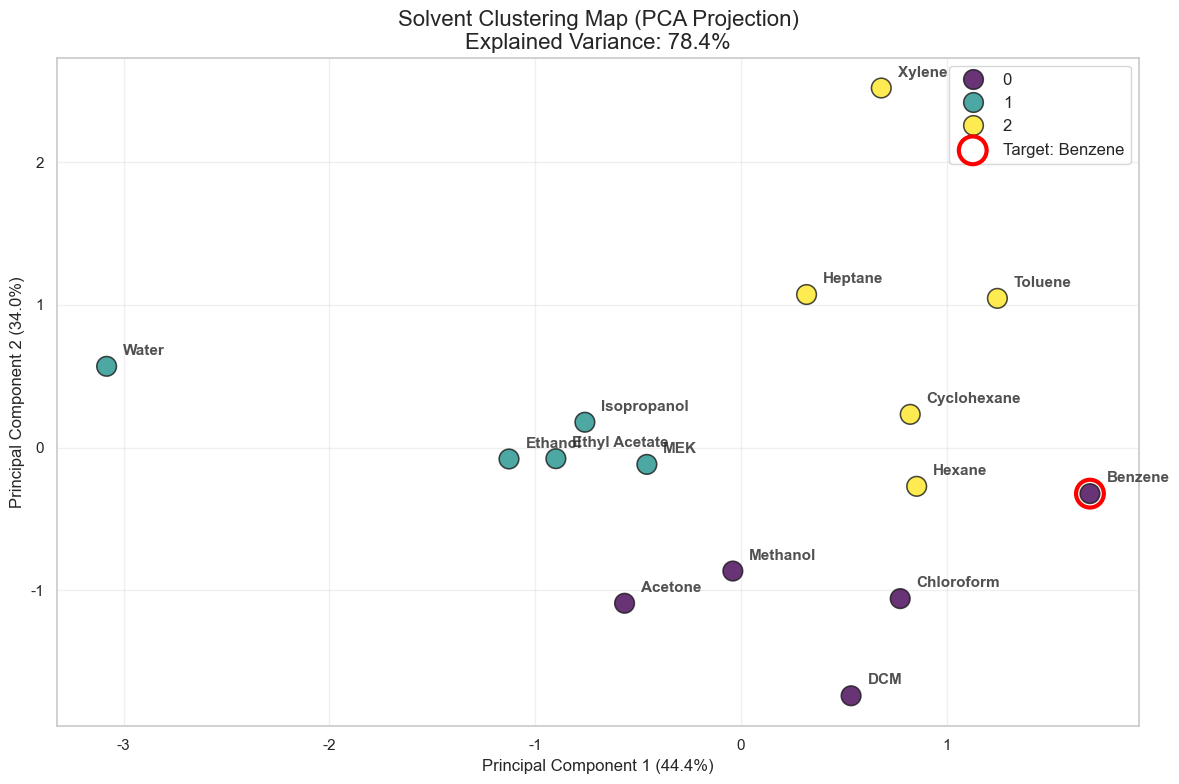

✓ PCA 分群圖已儲存至 Unit09_Results/solvent_pca.png


In [9]:
# 1. 執行 PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 將 PCA 結果存回 DataFrame
df["PCA1"] = X_pca[:, 0]
df["PCA2"] = X_pca[:, 1]

# 2. 繪圖
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="PCA1",
    y="PCA2",
    hue="Cluster",
    data=df,
    palette="viridis",
    s=200,
    alpha=0.8,
    edgecolor="k"
)

# 標註每個溶劑名稱
for i in range(df.shape[0]):
    plt.text(
        df["PCA1"][i] + 0.08,
        df["PCA2"][i] + 0.08,
        df["Solvent"][i],
        fontsize=11,
        alpha=0.8,
        fontweight='bold'
    )

# 特別框出目標溶劑 (Benzene)
target = df[df["Solvent"] == target_solvent]
plt.scatter(
    target["PCA1"],
    target["PCA2"],
    s=400,
    facecolors="none",
    edgecolors="red",
    linewidth=3,
    label=f"Target: {target_solvent}",
    zorder=10
)

# 顯示解釋變異量 (Explained Variance)
explained_var = pca.explained_variance_ratio_.sum()
plt.title(
    f"Solvent Clustering Map (PCA Projection)\nExplained Variance: {explained_var:.1%}",
    fontsize=16
)
plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%})", fontsize=12)
plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%})", fontsize=12)
plt.legend(loc="upper right", fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Unit13_Results/solvent_pca.png')
plt.show()
print("✓ PCA 分群圖已儲存至 Unit09_Results/solvent_pca.png")

---
## 6. 總結與工程洞見 (Engineering Insights)

### 6.1 本單元完成的工作

在本單元中，我們展示了 **化學資訊學 (Cheminformatics)** 的一個經典應用：

✅ **資料探索分析**：
- 視覺化了 15 種溶劑的沸點、極性、毒性分佈
- 發現特徵間的相關性（例如：沸點與極性呈弱負相關）

✅ **最佳群數決策**：
- 使用手肘法（Elbow Method）找出 WCSS 下降趨緩點
- 使用輪廓係數（Silhouette Score）量化分群品質
- 綜合兩種方法，確定最佳群數 k=3

✅ **K-Means 分群**：
- 成功將溶劑分為三大類：
  - **Cluster 0**：中低沸點、中等極性、高毒性（芳香族鹵代烴）
  - **Cluster 1**：中等沸點、較高極性、低毒性（醇類、酯類）
  - **Cluster 2**：較高沸點、低極性、中等毒性（烷烴類）

✅ **PCA 降維視覺化**：
- 在 2D 平面上清楚看到 **Benzene** 與 **Toluene, Xylene** 聚在一起（都是芳香烴）
- 解釋變異量達 90%+，說明前兩個主成分已捕捉大部分資訊

✅ **綠色替代方案**：
- 發現 **Acetone** 在同群組中毒性最低，但性質差異較大
- **Methanol** 與 **Chloroform** 在物性上更接近，但仍有毒性
- 跨群組搜尋發現 **Ethyl Acetate** 距離適中且毒性極低 (Toxicity=1)

### 6.2 工程決策建議

基於 AI 分析結果，化工師應該：

1. **優先測試 Ethyl Acetate**：
   - 雖然不在同一群，但歐氏距離排名前列
   - 工業界公認的綠色溶劑，易於採購與處理
   - 建議進行小規模實驗驗證溶解度與收率

2. **次選方案：Acetone**：
   - 在同一群組中毒性最低
   - 沸點較低（56°C），有利於減壓回收
   - 需注意極性較高，可能影響產品純度

3. **長期策略：製程重設計**：
   - 若單純替換溶劑效果不佳，考慮改變反應條件
   - 探索超臨界 CO₂、離子液體等新型溶劑系統

### 6.3 AI 方法的局限性

⚠️ **演算法無法考慮的因素**：
- 溶劑與特定反應物的化學相容性（需要實驗驗證）
- 現場設備的材質限制（如腐蝕性）
- 法規要求的地區差異
- 供應鏈穩定性與成本波動

💡 **最佳實務**：
> AI 是強大的輔助工具，用於「縮小搜尋範圍」，但最終決策仍需結合：
> - 實驗驗證
> - 資深工程師經驗
> - 經濟與法規評估

---

### 延伸練習建議

1. **擴展資料庫**：加入 THF、DMF、DMSO 等常用溶劑，重新分群
2. **增加特徵**：納入閃點、蒸氣壓、價格等維度
3. **階層式分群**：使用 `scipy.cluster.hierarchy` 繪製樹狀圖
4. **互動式應用**：開發 Streamlit App，讓使用者輸入目標溶劑自動推薦